In [21]:
import json
import sys
import os
import numpy as np
import skimage
from scipy import ndimage
from scipy import special
from scipy import sparse
import anndata
import nibabel as nib
import pandas as pd
import datashader as ds
import time
from sklearn.decomposition import PCA
import collections
import pickle as pkl
import zarr
import h5py
import anndata as ad

import ants
import nibabel as nib

sys.path.insert(0, '/home/fangming/projects/myutils')
from __init__plots import *
sns.set_style('white')

import importlib
import powerplots
importlib.reload(powerplots)
import imageu
importlib.reload(imageu)
import regu
importlib.reload(regu)

<module 'regu' from '/home/fangming/projects/myutils/regu.py'>

# Goals
- load allen data (mean expression)
- load dredFISH data
- load PNMF matrix

In [7]:
prj_dir = '/home/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'results/'
fig_dir = prj_dir + 'figures/'

# load allen matrix

In [13]:
ddir = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_CtxHippo/source/'
ddir = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_SmartSeq_CtxHippo/source/'

In [34]:
dataid = 'ctxhippo_ss_a'
output = f'{res_dir}{dataid}_organized.hdf5'
print(output)

/home/fangming/projects/dredfish/results/ctxhippo_ss_a_organized.hdf5


In [29]:
f = ddir + 'trimmed_means.csv'
mat1 = pd.read_csv(f).set_index('feature')

f = ddir + 'medians.csv'
mat2 = pd.read_csv(f).set_index('feature')

f = ddir + 'metadata.csv'
df1 = pd.read_csv(f).set_index('sample_name')
f = ddir + 'tsne.csv'
df2 = pd.read_csv(f).set_index('sample_name')
df = df1.join(df2) #.astype({'cluster_order': str})


data = {}
data['tmean'] = mat1
data['median'] = mat2
data['meta'] = df

/tmp/ipykernel_1701599/2601513464.py:8: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



In [30]:
# def save_hdf5(data_dict, file, force=False):
#     """
#     """
#     assert file.endswith('.hdf5')
#     if not force:
#         assert not os.path.isfile(file)

#     with h5py.File(file, 'w') as fh:
#         for key in data_dict.keys():
#             fh.create_dataset(key, data=data_dict[key])
#     print(f"saved to {file}")
    
#     return 

In [33]:
# output 3 matrices:
# tmean, median, meta

data['tmean'].to_hdf(output, 'tmean', mode='a')
data['median'].to_hdf(output, 'median', mode='a')
data['meta'].to_hdf(output, 'meta', mode='a')

/tmp/ipykernel_1701599/3315560548.py:6: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['donor_sex_label', 'donor_sex_color', 'region_label', 'region_color',
       'platform_label', 'cluster_label', 'cluster_color', 'subclass_label',
       'subclass_color', 'neighborhood_label', 'neighborhood_color',
       'class_label', 'class_color', 'exp_component_name',
       'external_donor_name_label', 'full_genotype_label',
       'facs_population_plan_label', 'injection_roi_label',
       'injection_materials_label', 'injection_method_label',
       'injection_type_label', 'full_genotype_color',
       'external_donor_name_color', 'facs_population_plan_color',
       'injection_materials_color', 'injection_method_color',
       'injection_roi_color', 'injection_type_color',
       'cell_type_accession_label', 'cell_type_alias_label',
       'cell_typ

In [38]:
data2 = pd.read_hdf(output, 'tmean')
data2

,108_Pvalb,229_L6 IT CTX,26_Ntng1 HPF,67_Sst,6_Lamp5 Lhx6,111_Pvalb,359_CA2-IG-FC,238_Car3,347_CA1-do,381_SMC-Peri,...,50_Vip,190_L4/5 IT CTX,207_L5/6 IT CTX,342_CA1,260_L5 PT CTX,324_ProS,178_L4 IT CTX,284_L6 CT CTX,377_Astro,298_L6 CT ENT
feature,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
0610007P14Rik,6.149091,6.844643,6.503429,6.368064,6.716667,6.123093,6.8675,7.097313,6.410685,2.8050,...,6.494454,6.175000,6.520834,6.937000,6.227551,6.77750,6.451691,6.607911,7.525000,6.529638
0610009B22Rik,6.393636,6.366785,6.951667,6.568254,6.811984,6.551165,5.9700,6.389925,6.239452,2.0975,...,6.431515,5.994375,6.242500,6.505333,6.221458,6.59125,6.113125,6.669403,1.761538,6.052993
0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.085833,0.000000,0.000000,0.000000,0.05200,0.000000,0.077822,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


# load dredFISH matrix

In [40]:
# dredFISH
f = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/results/labeled.h5ad'
data = ad.read_h5ad(f)
data

AnnData object with n_obs × n_vars = 97786 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'stage_x', 'stage_y', 'leiden', 'opt_types', 'Level_1_class_label_predicted', 'Level_2_neighborhood_label_predicted', 'Level_3_subclass_label_predicted', 'Level_4_supertype_label_predicted', 'Level_5_cluster_label_predicted'
    uns: 'leiden', 'neighbors'
    obsm: 'Level_1_class_label_predicted', 'Level_2_neighborhood_label_predicted', 'Level_3_subclass_label_predicted', 'Level_4_supertype_label_predicted', 'Level_5_cluster_label_predicted', 'stage'
    layers: 'DPNMF', 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors'
    obsp: 'connectivities', 'distances'

In [43]:
data.obs

,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,posname_stage_x,posname_stage_y,stage_x,stage_y,leiden,opt_types
0,1.0,2.184211,1036.754395,114.0,2240.0,99.0,1568.0,213.0,1920.0,Pos1,-3741.0,-3410.0,-3741.712053,-3747.981933,69,69
1,3.0,4.411765,371.397919,289.0,2496.0,232.0,1824.0,521.0,2256.0,Pos1,-3741.0,-3410.0,-3742.438235,-3531.075721,60,60
2,5.0,6.477124,862.071899,153.0,3136.0,566.0,3072.0,719.0,3088.0,Pos1,-3741.0,-3410.0,-3743.111542,-3691.035439,69,69
3,6.0,7.603730,952.538452,429.0,2320.0,65.0,1552.0,494.0,2176.0,Pos1,-3741.0,-3410.0,-3743.478816,-3720.527535,60,60
4,7.0,10.409292,145.630524,452.0,3536.0,616.0,2272.0,1068.0,2784.0,Pos1,-3741.0,-3410.0,-3744.393429,-3457.475551,69,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951-35,1052.0,2040.988525,1194.005737,348.0,1360.0,128.0,976.0,469.0,1248.0,Pos99,-1745.0,3525.0,-2410.362259,3135.754130,0,0_0
952-35,1053.0,2040.210083,1423.917603,376.0,2256.0,217.0,1568.0,593.0,2000.0,Pos99,-1745.0,3525.0,-2410.108487,3060.802862,0,0_2
953-35,1054.0,2042.615967,1494.047974,250.0,1504.0,70.0,832.0,318.0,1328.0,Pos99,-1745.0,3525.0,-2410.892805,3037.940361,18,18
954-35,1055.0,2043.655762,1652.926270,122.0,1008.0,74.0,992.0,192.0,992.0,Pos99,-1745.0,3525.0,-2411.231778,2986.146036,2,2


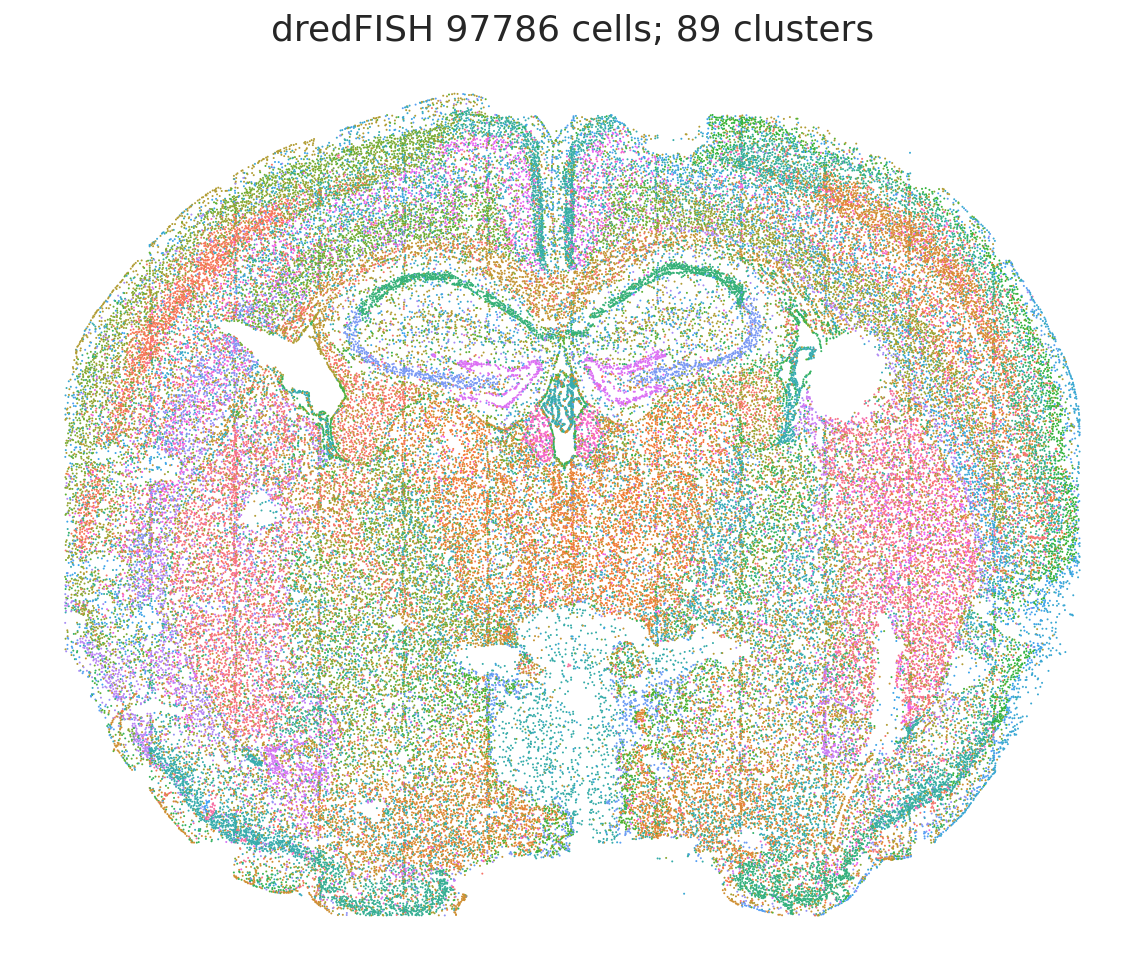

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=data.obs,
                x='stage_y',
                y='stage_x',
                hue='leiden',
                ax=ax,
                legend=False,
                s=1,
                edgecolor='none',
               )

n = len(data.obs['leiden'].unique())
ax.set_title(f"dredFISH {len(data.obs)} cells; {n} clusters")
ax.set_aspect('equal')
ax.axis('off')
plt.show()


In [53]:
data.X.shape

(97786, 24)

In [64]:
data.X # normalized somehow

array([[ 0.31305954,  0.16653173,  0.14215192, ...,  0.07231783,
         0.20829885,  0.18233976],
       [ 0.1240568 ,  0.37784585,  0.47153735, ...,  0.07814332,
         0.15456934,  0.21423572],
       [ 0.285935  ,  0.18951494,  0.14308624, ...,  0.20446725,
         0.21409354,  0.13887455],
       ...,
       [-0.08419434, -0.05871325, -0.04663565, ...,  0.02263566,
        -0.04005145, -0.0105409 ],
       [ 0.01110965,  0.01287316,  0.0361967 , ...,  0.9144609 ,
         0.04108392,  0.04593695],
       [ 0.20274548,  0.19979024,  0.18276827, ...,  0.22843441,
         0.15715098,  0.18876259]], dtype=float32)

# DPNMF matrix

In [68]:
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Ordered_Measurement_Matrix.csv'
pmat = pd.read_csv(f, index_col=0)
pmat

,RS0109_cy5,RS0175_cy5,RS0237_cy5,RS0307_cy5,RS0332_cy5,RS0384_atto565,RS0406_atto565,RS0451_atto565,RS0468_atto565,RS0548_atto565,...,RS643.0_alexa488,RS740.0_alexa488,RS810.0_alexa488,RSN9927.0_cy5,RSN2336.0_cy5,RSN1807.0_cy5,RSN4287.0_atto565,RSN1252.0_atto565,RSN9535.0_atto565,RS0095_cy5
Gm1992,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,20,0,0,0,0,0
Mrpl15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tcea1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atp6v1h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vamp7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tmlhe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC149090.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

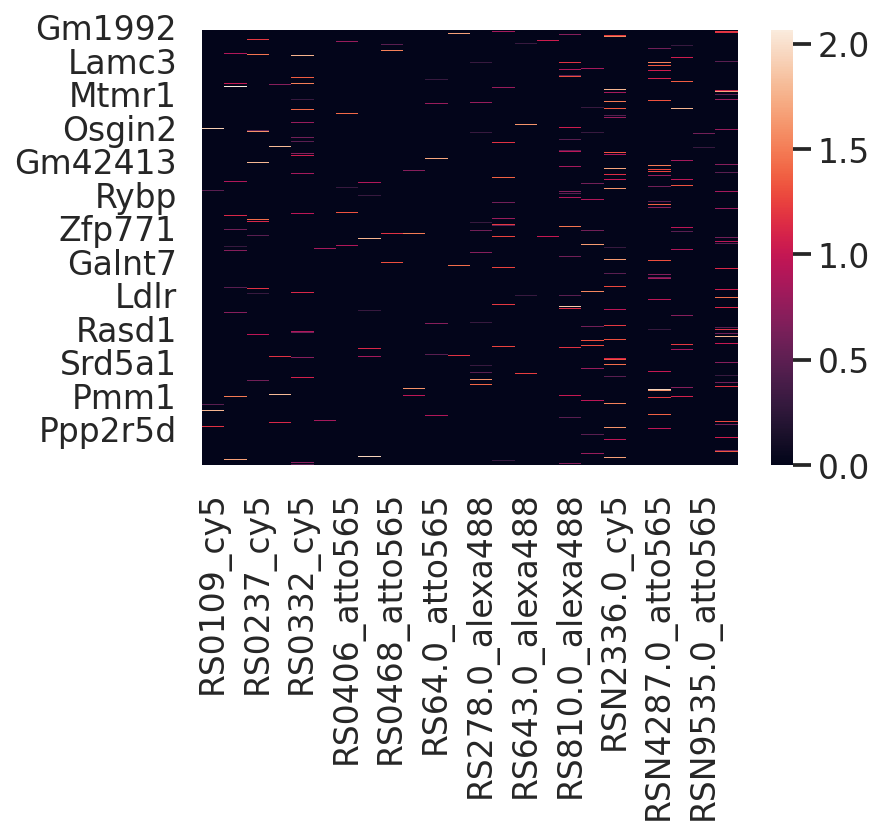

In [70]:
sns.heatmap(np.log10(pmat+1))